# Generative vs. Discriminative Models: Penguins Dataset

## Naive Bayes vs. Logistic Regression

This notebook compares **Naive Bayes** (generative) and **Logistic Regression** (discriminative) on the [Palmer Penguins](https://www.tensorflow.org/datasets/catalog/penguins) dataset, focusing on **Adelie** and **Gentoo** species only.

- **Generative model (Naive Bayes):** Models the joint distribution $P(X, Y)$.
- **Discriminative model (Logistic Regression):** Models the conditional distribution $P(Y|X)$ directly.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from IPython.display import display

np.random.seed(42)
print("Successful import.")

Successful import.


---
## Load Penguins dataset and filter Adelie & Gentoo

Load Palmer Penguins (4 features: bill length, bill depth, flipper length, body mass). Restrict to **Adelie** (0) and **Gentoo** (2), excluding Chinstrap. `X` and `y` are used in the accuracy-comparison cell below.

In [8]:
# csv avoids TFDS iteration, which hangs :/
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(url).dropna()
df = df[df["species"].isin(["Adelie", "Gentoo"])].copy()
feat = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feat].values.astype(np.float64)
y = df["species"].map({"Adelie": 0, "Gentoo": 2}).values.astype(np.int64)

counts = {int(k): int(v) for k, v in zip(*np.unique(y, return_counts=True))}
print("Adelie & Gentoo only: n =", len(y))
print("class counts:", counts)

Adelie & Gentoo only: n = 265
class counts: {0: 146, 2: 119}


## 1. Accuracy Comparison (Naive Bayes & Logistic Regression)

In [9]:
# use X, y from load cell above
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

nb = GaussianNB()
lr = LogisticRegression(max_iter=500, random_state=42)
nb.fit(X_train_s, y_train)
lr.fit(X_train_s, y_train)

# predictions and accuracy
y_train_nb = nb.predict(X_train_s)
y_test_nb = nb.predict(X_test_s)
y_train_lr = lr.predict(X_train_s)
y_test_lr = lr.predict(X_test_s)

acc = {
    "Naive Bayes": (accuracy_score(y_train, y_train_nb), accuracy_score(y_test, y_test_nb)),
    "Logistic Regression": (accuracy_score(y_train, y_train_lr), accuracy_score(y_test, y_test_lr)),
}
print("\n--- Accuracy Comparison (Adelie vs Gentoo) ---")
print(pd.DataFrame(acc, index=["Train", "Test"]).T.round(4).to_string())


--- Accuracy Comparison (Adelie vs Gentoo) ---
                     Train  Test
Naive Bayes            1.0   1.0
Logistic Regression    1.0   1.0


---
### Accuracy Comparison: Naive Bayes vs Logistic Regression

**Reported metrics:** Accuracy on the training and test sets for both models (Adelie vs Gentoo only), as shown in the table above.

**Findings:**  
Naive Bayes and Logistic Regression both achieved 100% accuracy on the training and test sets. Neither model better distinguishes the two species. Because the Adelie and Gentoo species are well separated in the 4-D feature space (bill length, bill depth, flipper length, body mass), a simple linear boundary (LR) and a simple class-conditional model (NB) each fit the data perfectly. When the classes are this separable, both can reach the same accuracy; on harder tasks with more overlap or correlated features, LR may have a small edge over NB.

## 2. AUC (Area Under the ROC Curve) Comparison

In [10]:
# using training, testing, nb, and lr from above
# predict_proba columns: [Adelie=0, Gentoo=2] → use P(Gentoo) = column 1 for AUC
p_train_nb = nb.predict_proba(X_train_s)[:, 1]
p_test_nb = nb.predict_proba(X_test_s)[:, 1]
p_train_lr = lr.predict_proba(X_train_s)[:, 1]
p_test_lr = lr.predict_proba(X_test_s)[:, 1]

# binarize for roc_auc_score
y_train_bin = (y_train == 2).astype(int)
y_test_bin = (y_test == 2).astype(int)

auc = {
    "Naive Bayes": (roc_auc_score(y_train_bin, p_train_nb), roc_auc_score(y_test_bin, p_test_nb)),
    "Logistic Regression": (roc_auc_score(y_train_bin, p_train_lr), roc_auc_score(y_test_bin, p_test_lr)),
}
print("--- AUC Comparison (Adelie vs Gentoo) ---")
print(pd.DataFrame(auc, index=["Train", "Test"]).T.round(4).to_string())

--- AUC Comparison (Adelie vs Gentoo) ---
                     Train  Test
Naive Bayes            1.0   1.0
Logistic Regression    1.0   1.0


### AUC interpretation and insights

**Interpretation:** AUC measures how well a model ranks positive (Gentoo) vs negative (Adelie) examples: AUC = 1.0 means perfect discrimination, which the NB and LR models acheivve.

**Findings:** Both models acheived AUC = 1.0 on train and test, since the two species are well separated (as discussed above). When AUC is equal, neither model is more effective at discrimination. If one model has higher test AUC than the other, that model better separates the two species in terms of predicted probabilities and is more effective (which is not the case here, as they are equally effective). AUC can differ from accuracy when models achieve similar accuracy but differ in confidence (probability calibration).

## 3. Lift and Gain Charts

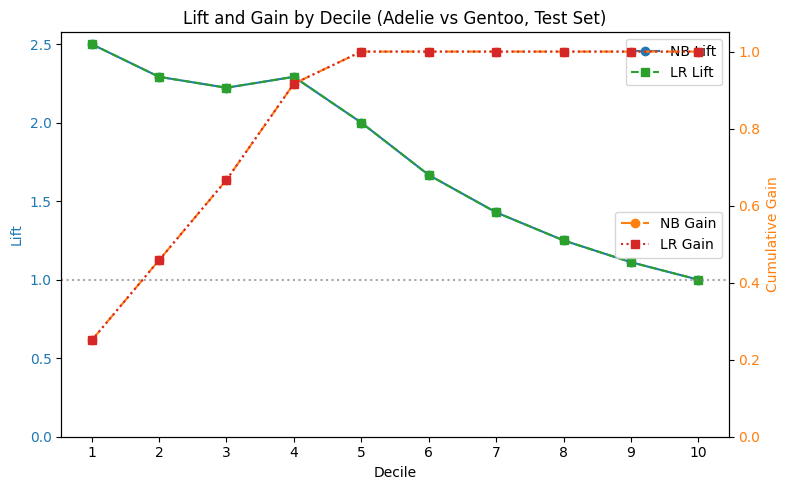

In [11]:
def lift_gain(y_true, y_score, n_deciles=10):
    """cumulative gain and lift by decile (top 10%, 20%, ..., 100%)."""
    order = np.argsort(y_score)[::-1]
    y_sorted = y_true[order]
    n = len(y_true)
    n_pos = int(y_true.sum())
    gain, lift = [], []
    for d in range(1, n_deciles + 1):
        frac = d / n_deciles
        k = min(int(np.ceil(n * frac)), n)
        cum_pos = y_sorted[:k].sum()
        g = cum_pos / n_pos if n_pos > 0 else 0
        gain.append(g)
        lift.append(g / frac if frac > 0 else 0)
    return np.array(gain), np.array(lift)

# use test-set probabilities and labels
try:
    _ = y_test
    _ = X_test_s
    _ = nb
    _ = lr
except NameError:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    nb = GaussianNB()
    lr = LogisticRegression(max_iter=500, random_state=42)
    nb.fit(X_train_s, y_train)
    lr.fit(X_train_s, y_train)

y_test_bin = (y_test == 2).astype(int)
p_test_nb = nb.predict_proba(X_test_s)[:, 1]
p_test_lr = lr.predict_proba(X_test_s)[:, 1]

n_deciles = 10
deciles = np.arange(1, n_deciles + 1)
gain_nb, lift_nb = lift_gain(y_test_bin, p_test_nb, n_deciles)
gain_lr, lift_lr = lift_gain(y_test_bin, p_test_lr, n_deciles)

fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel("Decile")
ax1.set_ylabel("Lift", color="C0")
ax1.set_xticks(deciles)
ax1.plot(deciles, lift_nb, "o-", color="C0", label="NB Lift")
ax1.plot(deciles, lift_lr, "s--", color="C2", label="LR Lift")
ax1.axhline(1, color="gray", linestyle=":", alpha=0.7)
ax1.tick_params(axis="y", labelcolor="C0")
ax1.legend(loc="upper right")
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative Gain", color="C1")
ax2.plot(deciles, gain_nb, "o-.", color="C1", label="NB Gain")
ax2.plot(deciles, gain_lr, "s:", color="C3", label="LR Gain")
ax2.tick_params(axis="y", labelcolor="C1")
ax2.legend(loc="center right")
ax2.set_ylim(0, 1.05)
plt.title("Lift and Gain by Decile (Adelie vs Gentoo, Test Set)")
fig.tight_layout()
plt.show()

### Lift and Gain evaluation

**Lift** (left y-axis): At each decile, Lift = (fraction of all positives captured in top *d*×10% of data) ÷ (*d*/10). Lift > 1 means the model concentrates positives in the top fraction better than random. (Lift = 1 is random).

**Cumulative Gain** (right y-axis): Fraction of all positives (Gentoos) captured when we take the top *d* deciles by predicted probability.

**Findings:** Lift starts high in the earliest deciles (the model concentrates Gentoos in the top-ranked fraction), then drops after the 4th decile as we include more of the population and the "bonus" over random shrinks. It reaches 1 at the 10th decile, when it has used 100% of the data and Lift equals the baseline. Gain starts at 0.2 in the first decile (the top 10% of cases captures ~20% of all Gentoos), rises through deciles 2–5 as it accumulates more positives, and flattens at 1.0 by the 5th decile, meaning all Gentoos have been captured in the top half of the ranked list. Both models show these patterns and effectively prioritize the classification of the two species. The curves are similar for Naive Bayes and Logistic Regression, consistent with their matched accuracy and AUC.
